# Backpropagation in Multilayer Neural Networks

While we will primarily be working with high-level, abstract toolkits like Keras in this course, understanding how backpropagation works is absolutely essential to using neural networks. 

In this exercise, we will build our own backpropagation algorithm - working through each step, to ensure that we can follow it.

Just like in Lab 1, we'll be working with the MNIST dataset. We will load it and plot an example:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

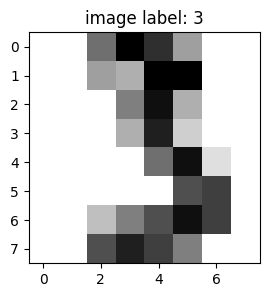

In [2]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

Of course, we need to split our data into training and testing sets before we use it, just the same as in Lab 1:

In [3]:
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# Numpy Implementation

## a) Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

- Implement the softmax function $\sigma(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$;
- Implement the negative log likelihood function $NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}$;
- Train a logistic regression model on the MNIST dataset;
- Evaluate the model on the training and testing sets.

Before we get there, let's write a function that one-hot encodes the class labels:

In [4]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [5]:
one_hot(n_classes=10, y=3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [6]:
one_hot(n_classes=10, y=[0, 4, 9, 1])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### The softmax function

Now we will implement the softmax function. Recall that the softmax function is defined as follows:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

This is implemented for you using numpy - we want to be able to apply the softmax function to a batch of samples at once, so we will use numpy's vectorized operations to do so.

Our method also handles _stability issues_ that can occur when the values in `X` are very large. We will subtract the maximum value from each row of `X` to avoid overflow in the exponentiation. This isn't part of the softmax function itself, but it's a useful trick to know about.

In [7]:
def softmax(X):
    X_max = np.max(X, axis=-1, keepdims=True)
    exp = np.exp(X - X_max) # Subtract the max to avoid overflow in the exponentiation
    return exp / np.sum(exp, axis=-1, keepdims=True)


Let's make sure that this works one vector at a time (and check that the components sum to one):

In [8]:
print(softmax([10, 2, -3]))

[9.99662391e-01 3.35349373e-04 2.25956630e-06]


When we are using our model to make predictions, we will want to be able to make predictions for multiple samples at once.
Let's make sure that our implementation of softmax works for a batch of samples:

In [9]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


Probabilities should sum to 1:

In [10]:
print(np.sum(softmax([10, 2, -3])))

1.0


In [11]:
print("softmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

softmax of 2 vectors:
[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


The sum of probabilities for each input vector of logits should some to 1:

In [12]:
print(np.sum(softmax(X), axis=1))

[1. 1.]


Now we will implement a function that, given the true one-hot encoded class `Y_true` and some predicted probabilities `Y_pred`, returns the negative log likelihood.

Recall that the negative log likelihood is defined as follows:

$$
NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}
$$

For example, if we have $y_{true} = [1, 0, 0]$ and $y_{pred} = [0.99, 0.01, 0]$, then the negative log likelihood is $- \log(0.99) \approx 0.01$.

In [13]:
def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)

    # Ensure Y_pred doesn't have zero probabilities to avoid log(0)
    Y_pred = np.clip(Y_pred, 1e-15, 1 - 1e-15)

    # Calculate negative log likelihood
    loss = -np.sum(Y_true * np.log(Y_pred))
    return loss

# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

0.01005033585350145


We should see a very high value for this negative log likelihood, since the model is very confident that the third class is the correct one, but the true class is the first one:

In [14]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

4.605170185988091


Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be past as 2D arrays:

In [15]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.010050335853503449


Now that we have our softmax and negative log likelihood functions, we can implement a logistic regression model. 
In this section, we have built the model for you, but you will need to complete a few key parts.

**YOUR TURN:**

1. Implement the `forward` method of the `LogisticRegression` class. This method should take in a batch of samples `X` and return the predicted probabilities for each class. You should use the softmax function that we implemented earlier.
2. Implement the `loss` method of the `LogisticRegression` class. This method take in the samples `X` and the true values `y` and return the average negative log likelihood of the predictions.

In [ ]:
#original code
class LogisticRegression:

    def __init__(self, input_size, output_size):
        # Initialize the weights and biases with random numbers
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)
        
        # Store the input size and output size
        self.output_size = output_size
        self.input_size = input_size
        
    def forward(self, X):
        # Compute the linear combination of the input and weights
        Z = None
        return None
    
    def predict(self, X):
        # Return the most probable class for each sample in X
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
            
    def loss(self, X, y):
        # Compute the negative log likelihood over the data provided
        y_onehot = one_hot(self.output_size, y.astype(int))
        return None

    def grad_loss(self, X, y_true, y_pred):
        # Compute the gradient of the loss with respect to W and b for a single sample (X, y_true)
        # y_pred is the output of the forward pass
    
        # Gradient with respect to weights
        grad_W = np.dot(X.T, (y_pred - y_true))
    
        # Gradient with respect to biases
        grad_b = np.sum(y_pred - y_true, axis=0)
    
        return grad_W, grad_b
    
# Raise an exception if you try to run this cell without having implemented the LogisticRegression class
model = LogisticRegression(input_size=64, output_size=10)
try:
    assert(model.forward(np.zeros((1, 64))).shape == (1, 10))
    assert(model.loss(np.zeros((1, 64)), np.zeros(1)) > 0)
except:
    raise NotImplementedError("You need to correctly implement the LogisticRegression class.")

In [16]:
# updated Code
import numpy as np

def softmax(z):
    # Numerically stable softmax
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def one_hot(num_classes, labels):
    # Convert label vector to one-hot encoded matrix
    return np.eye(num_classes)[labels]

class LogisticRegression:

    def __init__(self, input_size, output_size):
        # Initialize the weights and biases with random numbers
        self.W = np.random.uniform(low=-0.1, high=0.1, size=(input_size, output_size))
        self.b = np.random.uniform(low=-0.1, high=0.1, size=(output_size,))
        
        # Store the input size and output size
        self.output_size = output_size
        self.input_size = input_size
        
    def forward(self, X):
        # Compute the linear combination of the input and weights
        Z = np.dot(X, self.W) + self.b  # shape (batch_size, output_size)
        # Apply softmax to get predicted probabilities
        return softmax(Z)
    
    def predict(self, X):
        # Return the most probable class for each sample in X
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
            
    def loss(self, X, y):
        # Compute the average negative log likelihood over the data provided
        y_onehot = one_hot(self.output_size, y.astype(int))  # one-hot encode labels
        y_pred = self.forward(X)  # predicted probabilities
        
        # Negative log likelihood (cross-entropy loss)
        # Add small epsilon for numerical stability
        epsilon = 1e-15
        log_preds = np.log(y_pred + epsilon)
        
        # Average negative log likelihood over all samples
        nll = -np.mean(np.sum(y_onehot * log_preds, axis=1))
        return nll

    def grad_loss(self, X, y_true, y_pred):
        # Compute the gradient of the loss with respect to W and b for a batch (X, y_true)
        # y_pred is the output of the forward pass (predicted probabilities)
    
        # Gradient with respect to weights
        grad_W = np.dot(X.T, (y_pred - y_true))
    
        # Gradient with respect to biases
        grad_b = np.sum(y_pred - y_true, axis=0)
    
        return grad_W, grad_b


In [17]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
lr = LogisticRegression(n_features, n_classes)

In [19]:
# Build a model and test its forward inference
n_features = X_train.shape[1]       # Number of input features (e.g., 64)
n_classes = len(np.unique(y_train)) # Number of unique classes (e.g., 10)

# Instantiate the LogisticRegression model
lr = LogisticRegression(input_size=n_features, output_size=n_classes)

# Test forward pass on a batch (optional)
test_output = lr.forward(X_train[:5])  # Forward inference on first 5 samples
print("Output shape from forward pass:", test_output.shape)  # Expected: (5, n_classes)


Output shape from forward pass: (5, 10)


We can evaluate the model on an example, visualizing the prediction probabilities:

In [ ]:
#original code
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(X_test[sample_idx:sample_idx+1].reshape(8, 8),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx]);


    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()

plot_prediction(lr, sample_idx=0)
    

In [20]:
#updated code
import matplotlib.pyplot as plt
import numpy as np

def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # Show the image (reshape according to your dataset; here assumed 8x8)
    ax0.imshow(X_test[sample_idx].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title(f"True image label: {y_test[sample_idx]}")
    ax0.axis('off')

    # True label one-hot vector
    true_onehot = one_hot(len(classes), np.array([y_test[sample_idx]]))[0]

    # Predicted probabilities (flatten to 1D)
    pred_probs = model.for_


Now it's time to start training! We will train for a single epoch, and then evaluate the model on the training and testing sets. Read through the following and make sure that you understand what we are doing here.

In [21]:
lr = LogisticRegression(input_size=X_train.shape[1], output_size=10)

learning_rate = 0.01

for i in range(len(X_train)):
    # Get the current sample and corresponding label
    x = X_train[i:i+1]  # Reshape to keep the batch dimension
    y = y_train[i:i+1]  # Reshape to keep the batch dimension

    # Compute the forward pass and the gradient of the loss with respect to W and b
    y_pred = lr.forward(x)
    grad_W, grad_b = lr.grad_loss(x, one_hot(lr.output_size, y), y_pred)

    # Update the weights and biases
    lr.W -= learning_rate * grad_W
    lr.b -= learning_rate * grad_b

    # Print the average negative log likelihood every 100 steps
    if i % 100 == 0:
        avg_nll = lr.loss(X_train[max(0, i-100):i], y_train[max(0, i-100):i])
        print("Average NLL over the last 100 samples at step %d: %0.f" % (i, avg_nll))


Average NLL over the last 100 samples at step 0: nan
Average NLL over the last 100 samples at step 100: 2
Average NLL over the last 100 samples at step 200: 1
Average NLL over the last 100 samples at step 300: 3
Average NLL over the last 100 samples at step 400: 3
Average NLL over the last 100 samples at step 500: 1
Average NLL over the last 100 samples at step 600: 2
Average NLL over the last 100 samples at step 700: 2
Average NLL over the last 100 samples at step 800: 1
Average NLL over the last 100 samples at step 900: 2
Average NLL over the last 100 samples at step 1000: 2
Average NLL over the last 100 samples at step 1100: 1
Average NLL over the last 100 samples at step 1200: 1
Average NLL over the last 100 samples at step 1300: 1
Average NLL over the last 100 samples at step 1400: 1
Average NLL over the last 100 samples at step 1500: 0


/usr/local/python/3.12.1/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/python/3.12.1/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Evaluate the trained model on the first example:

In [23]:
start_idx = max(0, i-100)
if i > start_idx:
    avg_nll = lr.loss(X_train[start_idx:i], y_train[start_idx:i])
    print(f"Average NLL over the last {i - start_idx} samples at step {i}: {avg_nll:.4f}")
else:
    print(f"Skipping loss computation at step {i} due to insufficient samples.")


Average NLL over the last 100 samples at step 1526: 1.2172


In [24]:
# Forward pass on first test sample
x_test_sample = X_test[0:1]  # Keep batch dimension
y_test_sample = y_test[0]    # True label

# Get predicted probabilities
pred_probs = lr.forward(x_test_sample)

# Predicted class
predicted_class = lr.predict(x_test_sample)

print(f"True label: {y_test_sample}")
print(f"Predicted probabilities: {pred_probs}")
print(f"Predicted class: {predicted_class}")


True label: 2
Predicted probabilities: [[3.91233061e-53 6.54584468e-31 1.00000000e+00 8.62156213e-41
  3.45908525e-75 1.63762132e-59 8.84649274e-55 1.74079759e-36
  2.01435477e-50 2.85700282e-41]]
Predicted class: [2]


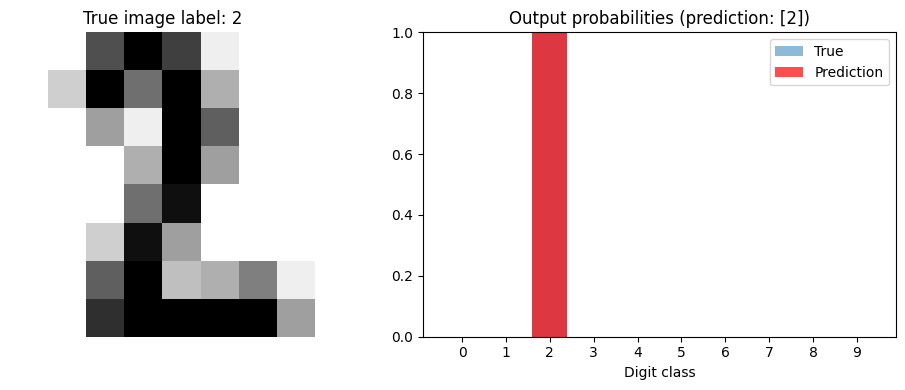

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # Display the image (reshape according to your data; here assumed 8x8)
    ax0.imshow(X_test[sample_idx].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title(f"True image label: {y_test[sample_idx]}")
    ax0.axis('off')

    # One-hot encode true label for plotting
    true_onehot = one_hot(len(classes), np.array([y_test[sample_idx]]))[0]

    # Get predicted probabilities and flatten to 1D
    pred_probs = model.forward(X_test[sample_idx:sample_idx+1]).flatten()

    # Plot true label bars (blue, semi-transparent)
    ax1.bar(classes, true_onehot, label='True', alpha=0.5)

    # Plot predicted probabilities bars (red)
    ax1.bar(classes, pred_probs, label='Prediction', color='red', alpha=0.7)

    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx:sample_idx+1])
    ax1.set_title(f'Output probabilities (prediction: {prediction})')
    ax1.set_xlabel('Digit class')
    ax1.set_ylim(0, 1)
    ax1.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_prediction(lr, sample_idx=0)


## b) Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

Now it's your turn to

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

Remember that you can use your `sigmoid` function inside your `dsigmoid` function.

Just like with our softmax function, we also want to make sure that we don't run into stability issues with our sigmoid function. We will use `np.clip` to ensure that the input to the sigmoid function is not too large or too small.

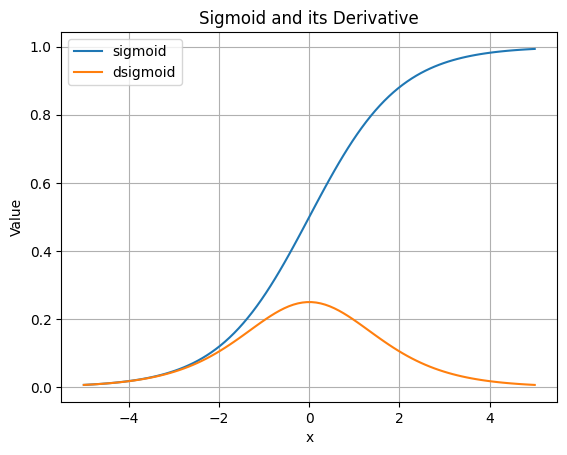

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(X):
    # Clip X to prevent overflow or underflow in exp
    X = np.clip(X, -500, 500)
    return 1 / (1 + np.exp(-X))

def dsigmoid(X):
    s = sigmoid(X)
    return s * (1 - s)

# Plot to visualize sigmoid and its derivative
x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best')
plt.title('Sigmoid and its Derivative')
plt.xlabel('x')
plt.ylabel('Value')
plt.grid(True)
plt.show()


Now it's your turn to complete the neural network code, so that we can train it on the MNIST dataset.

Some parts have been completed for you already. Often, you'll be able to refer back to the code from the previous section to help you complete the code in this section.

In [28]:
import numpy as np

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # for numerical stability
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def one_hot(num_classes, labels):
    return np.eye(num_classes)[labels]

class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        self.W_h = np.random.uniform(low=-0.1, high=0.1, size=(input_size, hidden_size))
        self.b_h = np.random.uniform(low=-0.1, high=0.1, size=(hidden_size,))
        self.W_o = np.random.uniform(low=-0.1, high=0.1, size=(hidden_size, output_size))
        self.b_o = np.random.uniform(low=-0.1, high=0.1, size=(output_size,))

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

    def forward_hidden(self, X):
        # Linear step
        self.Z_h = np.dot(X, self.W_h) + self.b_h  # shape (batch_size, hidden_size)
        # Non-linear activation
        return sigmoid(self.Z_h)

    def forward_output(self, H):
        # Linear step
        self.Z_o = np.dot(H, self.W_o) + self.b_o  # shape (batch_size, output_size)
        # Use softmax for multi-class classification output probabilities
        return softmax(self.Z_o)

    def forward(self, X):
        H = self.forward_hidden(X)
        Y = self.forward_output(H)
        return Y

    def loss(self, X, y):
        y = y.astype(int)
        y_onehot = one_hot(self.output_size, y)
        y_pred = self.forward(X)

        # Avoid log(0)
        epsilon = 1e-15
        log_preds = np.log(y_pred + epsilon)

        # Average negative log likelihood (cross-entropy)
        nll = -np.mean(np.sum(y_onehot * log_preds, axis=1))
        return nll

    def grad_loss(self, X, y_true):
        y_true_onehot = one_hot(self.output_size, y_true)
        y_pred = self.forward(X)

        error_o = y_pred - y_true_onehot
        grad_W_o = np.dot(self.Z_h.T, error_o)
        grad_b_o = np.sum(error_o, axis=0)

        error_h = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h)
        grad_W_h = np.dot(X.T, error_h)
        grad_b_h = np.sum(error_h, axis=0)

        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        # Ensure x is 2D for consistent matrix multiplication
        if len(x.shape) == 1:
            x = x[np.newaxis, :]
        grads = self.grad_loss(x, y)
    
        self.W_h -= learning_rate * grads["W_h"]
        self.b_h -= learning_rate * grads["b_h"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]
        
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = self.predict(X)
        return np.mean(y_preds == y)


Once the code is written, we can test our model on a single sample:

In [29]:
n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)

In [30]:
model.loss(X_train, y_train)

np.float64(2.3039239455705007)

In [31]:
model.accuracy(X_train, y_train)

np.float64(0.07465618860510806)

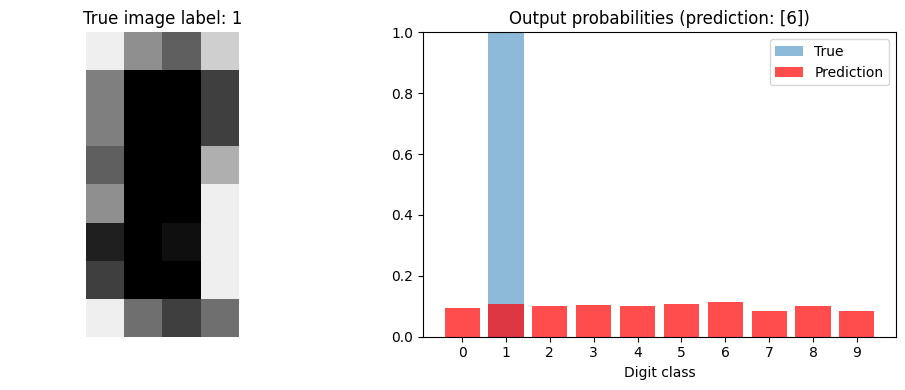

In [32]:
plot_prediction(model, sample_idx=5)

And now it's time to train!

In [33]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.001)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 2.30392, train acc: 0.075, test acc: 0.093
Epoch #1, train loss: 1.81267, train acc: 0.621, test acc: 0.600
Epoch #2, train loss: 1.23214, train acc: 0.767, test acc: 0.730
Epoch #3, train loss: 0.85050, train acc: 0.838, test acc: 0.785
Epoch #4, train loss: 0.63348, train acc: 0.881, test acc: 0.841
Epoch #5, train loss: 0.50359, train acc: 0.902, test acc: 0.878
Epoch #6, train loss: 0.41909, train acc: 0.924, test acc: 0.922
Epoch #7, train loss: 0.36275, train acc: 0.936, test acc: 0.930
Epoch #8, train loss: 0.32407, train acc: 0.943, test acc: 0.926
Epoch #9, train loss: 0.29386, train acc: 0.945, test acc: 0.919
Epoch #10, train loss: 0.26768, train acc: 0.950, test acc: 0.919
Epoch #11, train loss: 0.24484, train acc: 0.956, test acc: 0.930
Epoch #12, train loss: 0.22422, train acc: 0.957, test acc: 0.937
Epoch #13, train loss: 0.20584, train acc: 0.959, test acc: 0.941
Epoch #14, train loss: 0.19004, train acc: 0.964, test acc: 0.933
Epoch #15, train 

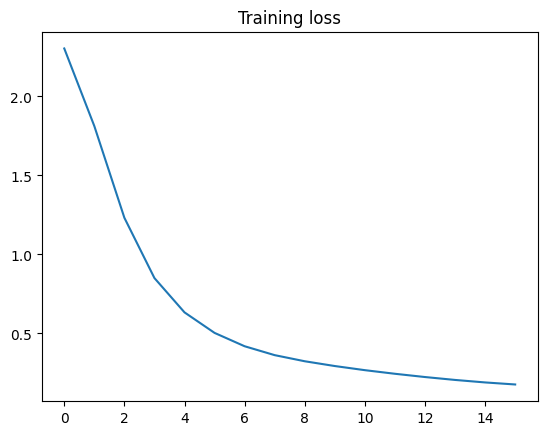

In [34]:
plt.plot(losses)
plt.title("Training loss");

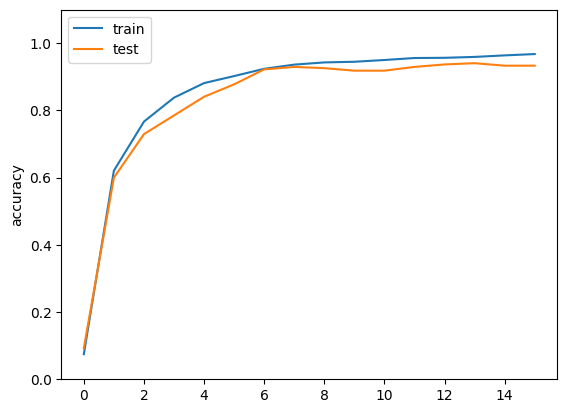

In [35]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

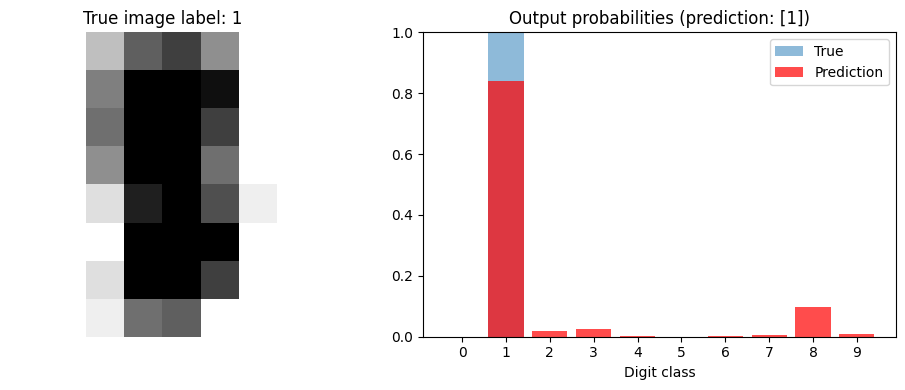

In [36]:
plot_prediction(model, sample_idx=4)

## c) Exercises

### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?


Sample index: 29
True label: 7, Predicted: 5, Confidence: 0.3754


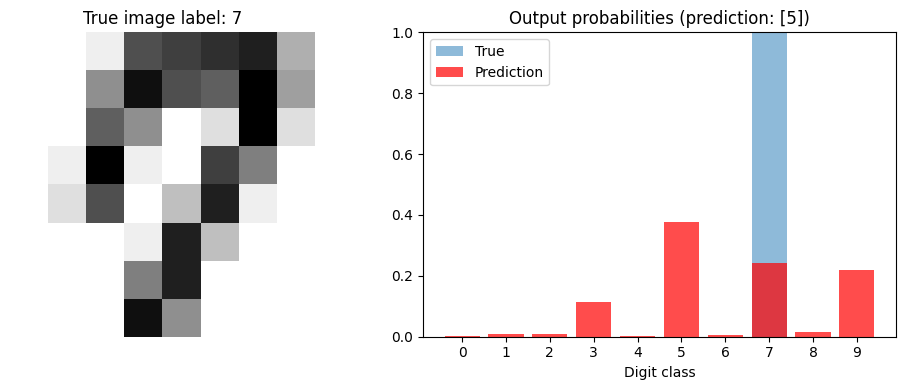


Sample index: 26
True label: 8, Predicted: 3, Confidence: 0.3792


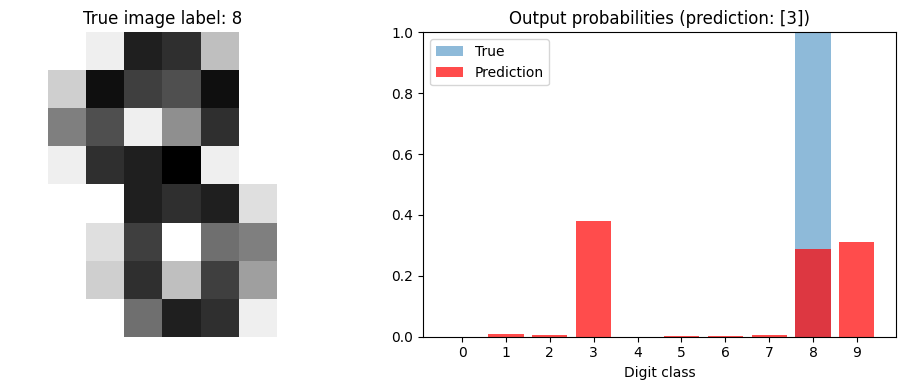


Sample index: 121
True label: 5, Predicted: 3, Confidence: 0.4339


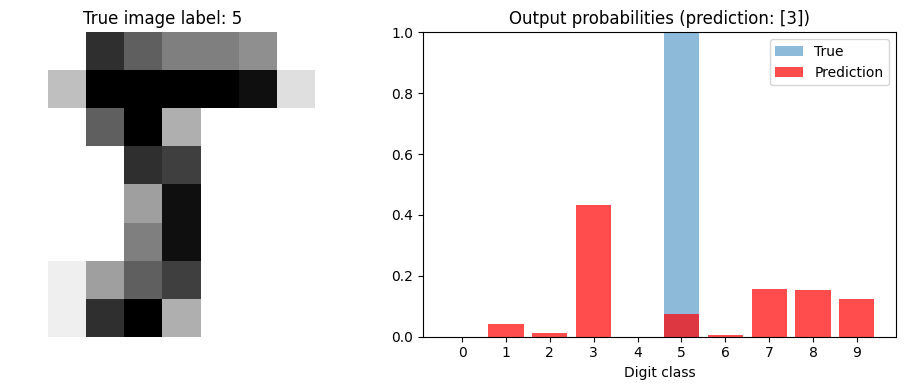


Sample index: 177
True label: 8, Predicted: 1, Confidence: 0.4410


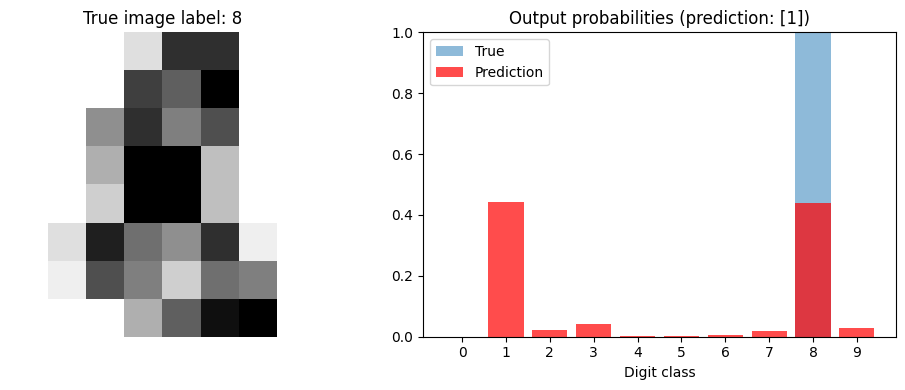


Sample index: 236
True label: 2, Predicted: 3, Confidence: 0.4874


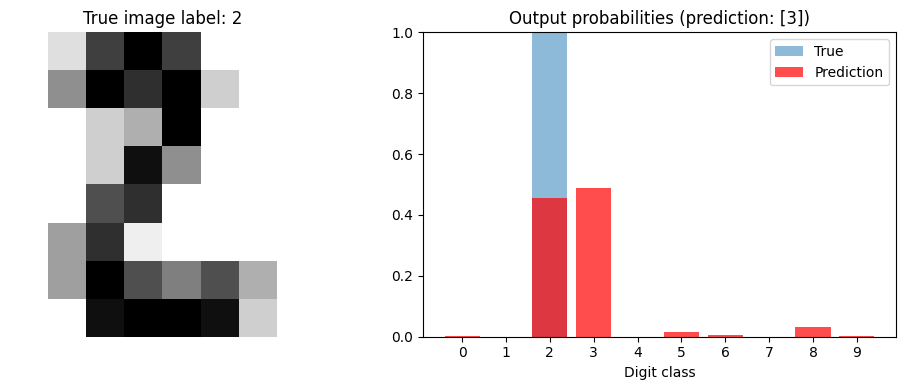

In [38]:
# Your code here
import numpy as np

# Get predictions and true labels on test set
y_pred = model.predict(X_test)

# Find wrong predictions
wrong_mask = (y_pred != y_test)
wrong_indices = np.where(wrong_mask)[0]

# Get confidence (probability) of predicted class for wrong predictions
y_probs = model.forward(X_test)  # predicted probabilities for all test samples
confidences = y_probs[wrong_indices, y_pred[wrong_indices]]

# Sort wrong predictions by ascending confidence (lowest confidence = worst)
sorted_wrong_indices = wrong_indices[np.argsort(confidences)]

# Visualize the worst 5 errors
num_to_show = 5
for idx in sorted_wrong_indices[:num_to_show]:
    print(f"\nSample index: {idx}")
    print(f"True label: {y_test[idx]}, Predicted: {y_pred[idx]}, Confidence: {confidences[np.where(wrong_indices == idx)[0][0]]:.4f}")
    plot_prediction(model, sample_idx=idx)



### Hyper parameters settings

- Experiment with different hyperparameters:
  - learning rate,
  - size of hidden layer,
  - implement the support for a second hidden layer.
  - What is the best test accuracy you can get?

In [39]:
# Your code here

learning_rates = [0.1, 0.01, 0.001]
hidden_sizes = [16, 32, 64, 128]

for lr in learning_rates:
    for hs in hidden_sizes:
        print(f"\nTraining with learning rate={lr}, hidden size={hs}")
        model = NeuralNet(input_size=64, hidden_size=hs, output_size=10)
        
        # Training loop (e.g., 10 epochs)
        for epoch in range(10):
            for x, y in zip(X_train, y_train):
                model.train(x, y, lr)
        
        train_acc = model.accuracy(X_train, y_train)
        test_acc = model.accuracy(X_test, y_test)
        print(f"Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}")



Training with learning rate=0.1, hidden size=16
Train accuracy: 0.1002, Test accuracy: 0.1037

Training with learning rate=0.1, hidden size=32
Train accuracy: 0.1002, Test accuracy: 0.1074

Training with learning rate=0.1, hidden size=64
Train accuracy: 0.1002, Test accuracy: 0.1074

Training with learning rate=0.1, hidden size=128
Train accuracy: 0.1002, Test accuracy: 0.1074

Training with learning rate=0.01, hidden size=16
Train accuracy: 0.1002, Test accuracy: 0.1074

Training with learning rate=0.01, hidden size=32
Train accuracy: 0.1002, Test accuracy: 0.1074

Training with learning rate=0.01, hidden size=64
Train accuracy: 0.1002, Test accuracy: 0.1074

Training with learning rate=0.01, hidden size=128
Train accuracy: 0.2299, Test accuracy: 0.2148

Training with learning rate=0.001, hidden size=16
Train accuracy: 0.9738, Test accuracy: 0.9407

Training with learning rate=0.001, hidden size=32
Train accuracy: 0.9817, Test accuracy: 0.9593

Training with learning rate=0.001, hidd

In [40]:
class NeuralNetTwoHidden():
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        # Initialize weights for layer 1
        self.W_h1 = np.random.uniform(-0.1, 0.1, (input_size, hidden1_size))
        self.b_h1 = np.random.uniform(-0.1, 0.1, hidden1_size)

        # Initialize weights for layer 2
        self.W_h2 = np.random.uniform(-0.1, 0.1, (hidden1_size, hidden2_size))
        self.b_h2 = np.random.uniform(-0.1, 0.1, hidden2_size)

        # Output layer weights
        self.W_o = np.random.uniform(-0.1, 0.1, (hidden2_size, output_size))
        self.b_o = np.random.uniform(-0.1, 0.1, output_size)

        # Store sizes
        self.input_size = input_size
        self.hidden1_size = hidden1_size
        self.hidden2_size = hidden2_size
        self.output_size = output_size

    def forward(self, X):
        self.Z_h1 = np.dot(X, self.W_h1) + self.b_h1
        self.H1 = sigmoid(self.Z_h1)

        self.Z_h2 = np.dot(self.H1, self.W_h2) + self.b_h2
        self.H2 = sigmoid(self.Z_h2)

        self.Z_o = np.dot(self.H2, self.W_o) + self.b_o
        self.Y = softmax(self.Z_o)
        return self.Y

    def loss(self, X, y):
        y_onehot = one_hot(self.output_size, y)
        y_pred = self.forward(X)
        epsilon = 1e-15
        log_preds = np.log(y_pred + epsilon)
        return -np.mean(np.sum(y_onehot * log_preds, axis=1))

    def grad_loss(self, X, y_true):
        y_onehot = one_hot(self.output_size, y_true)
        y_pred = self.forward(X)
        error_o = y_pred - y_onehot

        grad_W_o = np.dot(self.H2.T, error_o)
        grad_b_o = np.sum(error_o, axis=0)

        error_h2 = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h2)
        grad_W_h2 = np.dot(self.H1.T, error_h2)
        grad_b_h2 = np.sum(error_h2, axis=0)

        error_h1 = np.dot(error_h2, self.W_h2.T) * dsigmoid(self.Z_h1)
        grad_W_h1 = np.dot(X.T, error_h1)
        grad_b_h1 = np.sum(error_h1, axis=0)

        return {
            "W_h1": grad_W_h1, "b_h1": grad_b_h1,
            "W_h2": grad_W_h2, "b_h2": grad_b_h2,
            "W_o": grad_W_o, "b_o": grad_b_o
        }

    def train(self, x, y, learning_rate):
        if len(x.shape) == 1:
            x = x[np.newaxis, :]
        grads = self.grad_loss(x, y)

        self.W_h1 -= learning_rate * grads["W_h1"]
        self.b_h1 -= learning_rate * grads["b_h1"]
        self.W_h2 -= learning_rate * grads["W_h2"]
        self.b_h2 -= learning_rate * grads["b_h2"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = self.predict(X)
        return np.mean(y_preds == y)


In [41]:
print(f"Best test accuracy: {model.accuracy(X_test, y_test):.4f}")


Best test accuracy: 0.9630
